In [1]:
import bitdotio 
from pprintpp import pprint

b = bitdotio.bitdotio(<password>)

conn = b.get_connection(<db>)
cur = conn.cursor()
cur.execute("SELECT 1")
pprint(cur.fetchone())

(1, )


In [2]:
import csv
from io import StringIO
import time

import pandas as pd
from sqlalchemy import create_engine
#from config import pg_string

In [3]:
# Create SQLAlchemy engine to manage our database connections
# Note that we bump the statement_timeout to 60 seconds
# pool_pre_ping=True 
engine = create_engine(<postgresqlstring>
                       , pool_pre_ping=True)
# SQL for querying an entire table
sql = f'''
    SELECT *
    FROM "filled_final_table";
'''
# Return SQL query as a pandas dataframe
with engine.connect() as conn:
    # Set 1 minute statement timeout (units are milliseconds)
    conn.execute("SET statement_timeout = 60000;")
    df = pd.read_sql(sql, conn)
df.head()

,date,year,county,median_listing_price,active_listing_count,median_days_on_market,new_listing_count,price_increased_count,price_reduced_count,median_square_feet,average_listing_price,total_listing_count,violent_crime_rate,30_year_fixed_rate,number_of_schools,median_listing_price_mm,number_of_parks
0,2022-06,2022,Alamance,382500,298,18,452,12,108,2112,443362,644,None,5.52,NaN,0.034063,54.0
1,2022-06,2022,Alexander,312450,34,35,28,0,20,1942,370648,59,None,5.52,NaN,0.016428,25.0
2,2022-06,2022,Alleghany,389000,54,39,24,0,20,1904,422802,92,None,5.52,NaN,-0.038200,0.0
3,2022-06,2022,Anson,170000,22,34,16,0,8,1502,262240,48,None,5.52,NaN,0.218638,3.0
4,2022-06,2022,Ashe,485000,76,31,48,0,20,1907,592879,137,None,5.52,NaN,-0.088346,5.0


In [18]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [5]:
#conditional based column = np.where(df['median_listing_price_mm'] (x>=0), 'up(1)', 'down(0)')
df['Price_Status'] = np.where(df['median_listing_price_mm']>=0, 1, 0)
df['violent_crime_rate']= df['violent_crime_rate'].str.replace(',','').astype(float)
df.head()

,date,year,county,median_listing_price,active_listing_count,median_days_on_market,new_listing_count,price_increased_count,price_reduced_count,median_square_feet,average_listing_price,total_listing_count,violent_crime_rate,30_year_fixed_rate,number_of_schools,median_listing_price_mm,number_of_parks,Price_Status
0,2022-06,2022,Alamance,382500,298,18,452,12,108,2112,443362,644,NaN,5.52,NaN,0.034063,54.0,1
1,2022-06,2022,Alexander,312450,34,35,28,0,20,1942,370648,59,NaN,5.52,NaN,0.016428,25.0,1
2,2022-06,2022,Alleghany,389000,54,39,24,0,20,1904,422802,92,NaN,5.52,NaN,-0.038200,0.0,0
3,2022-06,2022,Anson,170000,22,34,16,0,8,1502,262240,48,NaN,5.52,NaN,0.218638,3.0,1
4,2022-06,2022,Ashe,485000,76,31,48,0,20,1907,592879,137,NaN,5.52,NaN,-0.088346,5.0,0


Price Status for the classes are: Price_Status
0    3017
1    4179
dtype: int64


<AxesSubplot:xlabel='Price_Status'>

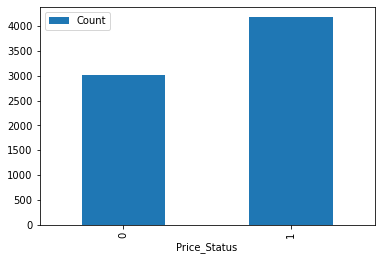

In [6]:
 #Get a count of each class for the price status
df.groupby('Price_Status').count()
print('Price Status for the classes are:', df.groupby('Price_Status').size())
plot_df = df[['Price_Status', 'year']]
plot_by_df = plot_df.rename(columns={"year": "Count"})
plot_by_df.groupby('Price_Status').count().plot.bar()

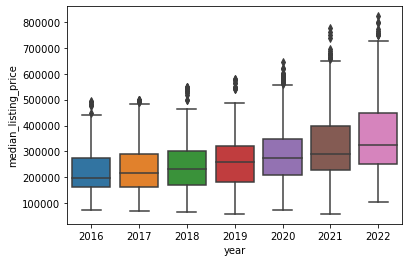

In [7]:
ax = sns.boxplot(x="year", y="median_listing_price", data=df)

In [8]:
df_new1 = df.drop(['date'], axis=1)
df_new1.dtypes

year                         int64
county                      object
median_listing_price         int64
active_listing_count         int64
median_days_on_market        int64
new_listing_count            int64
price_increased_count        int64
price_reduced_count          int64
median_square_feet           int64
average_listing_price        int64
total_listing_count          int64
violent_crime_rate         float64
30_year_fixed_rate         float64
number_of_schools          float64
median_listing_price_mm    float64
number_of_parks            float64
Price_Status                 int32
dtype: object

In [9]:
filter_df = df_new1[df_new1['year'] <2019]
filter_df["year"].unique()

array([2018, 2017, 2016], dtype=int64)

In [10]:
len(filter_df)

3000

In [11]:
# leave 'median_listing_price' in columns? Price_Status is classifier for median_listing_price (increased(up)/decreased(down))
columns = [
      "county", "year",
    "active_listing_count", "median_days_on_market", "new_listing_count",
    "price_increased_count", "price_reduced_count", "median_square_feet",
    "total_listing_count", "violent_crime_rate","number_of_parks",
    "number_of_schools","30_year_fixed_rate", 
     "Price_Status"]

# conditional column 'Price_status' is condition on 'median_listing...mm' which is "the percentage change
# in the median listing price from the previous month." An increase is 'up', decrease is 'down'.

# df['Price_Status'] = np.where(df['median_listing_price_mm']>=0, 'up', 'down')


# https://www.realtor.com/research/data/

target = ["Price_Status"]

In [12]:
# Load the data

df_data = filter_df.loc[:, columns].copy()
df_data = df_data.dropna()

df_data.reset_index(inplace=True, drop=True)

df_data.head()
len(df_data)

2610

Price Status for the classes are: Price_Status
0    1162
1    1448
dtype: int64


<AxesSubplot:xlabel='Price_Status'>

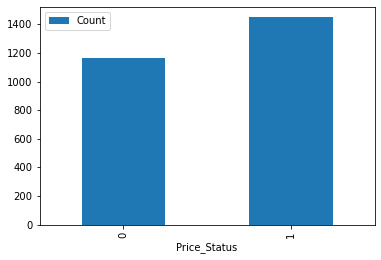

In [13]:
# Get a count of each class for the price status

print('Price Status for the classes are:', df_data.groupby('Price_Status').size())
plot_df = df_data[['Price_Status', 'year']]
plot_by_df = plot_df.rename(columns={"year": "Count"})
plot_by_df.groupby('Price_Status').count().plot.bar()

SPLIT TEST TRAIN

In [14]:
# Create our features
X = df_data.drop('Price_Status', axis=1)

X = pd.get_dummies(X)

# Create our target
y = df_data.loc[:, target].copy()


In [15]:
# Check the balance of our target values
y.value_counts()

Price_Status
1               1448
0               1162
dtype: int64

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                  stratify=y)
X_train.shape


(1957, 104)

ADABOOST Classifier

In [19]:
#preprocess data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)


In [20]:
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
ad_model = AdaBoostClassifier(n_estimators=200, random_state=1) 
ad_model = ad_model.fit(X_train_scale, y_train)
y_pred = ad_model.predict(X_test_scale)
accuracy_score( y_test, y_pred)

0.5620214395099541

In [21]:
# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.42      0.46       291
           1       0.59      0.68      0.63       362

    accuracy                           0.56       653
   macro avg       0.55      0.55      0.55       653
weighted avg       0.56      0.56      0.56       653



In [23]:
# List the features sorted in descending order by feature importance
sorted(zip(ad_model.feature_importances_, X.columns), reverse=True)

[(0.14, 'median_square_feet'),
 (0.135, 'median_days_on_market'),
 (0.125, 'new_listing_count'),
 (0.12, 'total_listing_count'),
 (0.105, 'active_listing_count'),
 (0.08, 'price_reduced_count'),
 (0.05, '30_year_fixed_rate'),
 (0.035, 'violent_crime_rate'),
 (0.03, 'price_increased_count'),
 (0.03, 'number_of_schools'),
 (0.01, 'year'),
 (0.005, 'number_of_parks'),
 (0.005, 'county_Warren'),
 (0.005, 'county_Union'),
 (0.005, 'county_Tyrrell'),
 (0.005, 'county_Transylvania'),
 (0.005, 'county_Swain'),
 (0.005, 'county_Surry'),
 (0.005, 'county_Stanly'),
 (0.005, 'county_Rutherford'),
 (0.005, 'county_Orange'),
 (0.005, 'county_Northampton'),
 (0.005, 'county_Moore'),
 (0.005, 'county_Martin'),
 (0.005, 'county_Madison'),
 (0.005, 'county_Lenoir'),
 (0.005, 'county_Jackson'),
 (0.005, 'county_Guilford'),
 (0.005, 'county_Granville'),
 (0.005, 'county_Edgecombe'),
 (0.005, 'county_Durham'),
 (0.005, 'county_Davidson'),
 (0.005, 'county_Craven'),
 (0.005, 'county_Columbus'),
 (0.005, 'co

## Hypertune Features

In [24]:
ad_model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 200,
 'random_state': 1}

In [27]:
from sklearn.model_selection import RandomizedSearchCV

# Create the random grid search to use to find the best hyperparameters
random_grid = {'n_estimators': [100,200,300,400],
               'algorithm': ['SAMME','SAMME.R']}

ad = AdaBoostClassifier()
# using 3 fold of cross validation, radom search parameters with 100 different combinations. 

ad_search = RandomizedSearchCV(ad, random_grid,
               n_iter = 100, cv =3, verbose = 2, random_state = 1)

# fit to model

ad_search.fit(X_train_scale, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..................algorithm=SAMME, n_estimators=100; total time=   0.7s
[CV] END ..................algorithm=SAMME, n_estimators=100; total time=   1.9s
[CV] END ..................algorithm=SAMME, n_estimators=100; total time=   1.8s
[CV] END ..................algorithm=SAMME, n_estimators=200; total time=   3.4s
[CV] END ..................algorithm=SAMME, n_estimators=200; total time=   4.0s
[CV] END ..................algorithm=SAMME, n_estimators=200; total time=   3.9s
[CV] END ..................algorithm=SAMME, n_estimators=300; total time=   3.6s
[CV] END ..................algorithm=SAMME, n_estimators=300; total time=   2.0s
[CV] END ..................algorithm=SAMME, n_estimators=300; total time=   4.3s
[CV] END ..................algorithm=SAMME, n_estimators=400; total time=   7.4s
[CV] END ..................algorithm=SAMME, n_estimators=400; total time=   4.2s
[CV] END ..................algorithm=SAMME, n_est

RandomizedSearchCV(cv=3, estimator=AdaBoostClassifier(), n_iter=100,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=1, verbose=2)

In [29]:
print(ad_search.best_params_)
print(ad_search.best_score_)

{'n_estimators': 100, 'algorithm': 'SAMME'}
0.5728140061443644


## Run AdaBoostClassifier with best parameters

In [37]:
# predictions based on best parameters
AdaBoostClassifierPred = ad_search.predict(X_test_scale)
confusion_matrix(y_test, y_pred)

array([[122, 169],
       [117, 245]], dtype=int64)

In [38]:
# Print classification report
print(classification_report(y_test, AdaBoostClassifierPred))

              precision    recall  f1-score   support

           0       0.62      0.23      0.33       291
           1       0.59      0.89      0.71       362

    accuracy                           0.59       653
   macro avg       0.61      0.56      0.52       653
weighted avg       0.60      0.59      0.54       653



## AdaboostClassifier built with best parameters


In [43]:
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
ad_model1 = AdaBoostClassifier(n_estimators=100, algorithm = 'SAMME', random_state=1) 
ad_model1 = ad_model1.fit(X_train_scale, y_train)
y_pred1 = ad_model1.predict(X_test_scale)
accuracy_score( y_test, y_pred)

0.5941807044410413

In [44]:
# Print classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.62      0.23      0.33       291
           1       0.59      0.89      0.71       362

    accuracy                           0.59       653
   macro avg       0.61      0.56      0.52       653
weighted avg       0.60      0.59      0.54       653

